# Capstone - Step2: Data Wrangling and Exploration  |  source: Google Earth Engine
<hr style="border:2px solid #007700;">

In [3]:
import ee
import geemap

# Authenticate the Earth Engine API.
ee.Authenticate()

# Initialize the Earth Engine API.
ee.Initialize(project='ee-fperezbessi') #<- a valid client project ID or number is needed for initialization

In [4]:
# Time range
start_date = '2023-08-31'
end_date = '2024-08-31'

In [5]:
from geopy.distance import geodesic

# Define de ROI bbox

center_point = (-15.753758452903798, -47.7330090496202)

# Define the distance to extend
distance_km = 1.5

# Calculate the boundary box
bb_north = geodesic(kilometers=distance_km).destination(center_point, 0).latitude
bb_south = geodesic(kilometers=distance_km).destination(center_point, 180).latitude
bb_east = geodesic(kilometers=distance_km).destination(center_point, 90).longitude
bb_west = geodesic(kilometers=distance_km).destination(center_point, 270).longitude
bbox = (bb_west, bb_south, bb_east, bb_north)

print(f"Bounding box:\nSouth: {bb_south} \tWest: {bb_west}\nNorth: {bb_north} \tEast: {bb_east}")
print(f"bbox = {bbox}")

Bounding box:
South: -15.767313946577834 	West: -47.747006223606235
North: -15.7402029423913 	East: -47.719011875634166
bbox = (-47.747006223606235, -15.767313946577834, -47.719011875634166, -15.7402029423913)


In [6]:
# Initialize the EE BBox
bbox = ee.Geometry.BBox(bb_west, bb_south, bb_east, bb_north)



In [7]:
# Load the Sentinel-2 image collection for Level-2A data (Surface Reflectance)
sentinel_2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
              .filterDate(start_date, end_date) \
              .filterBounds(bbox) \
              .sort('system:time_start')  # Sort by date (oldest first)

In [8]:
# Display relevant information about the collection
print("Sentinel-2 Collection Information:")
print(f"Type: {sentinel_2.getInfo().get('type')}")
print(f"ID: {sentinel_2.getInfo().get('id')}")
print(f"Number of Images: {sentinel_2.size().getInfo()}")

Sentinel-2 Collection Information:
Type: ImageCollection
ID: COPERNICUS/S2_SR_HARMONIZED
Number of Images: 287


In [9]:
# Retrieve the first image and display image metadata
image = sentinel_2.first()
image_info = image.getInfo()

print("\nImage Information:")
print(f"ID: {image_info['id']}")
print(f"Available Bands: {[band['id'] for band in image_info['bands']]}")
print(f"Date: {ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()}")
print(f"Cloud Cover: {image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()}%")


Image Information:
ID: COPERNICUS/S2_SR_HARMONIZED/20230901T132241_20230901T132251_T23LKC
Available Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']
Date: 2023-09-01
Cloud Cover: 0.917107%


# Using geemap and NumPy to visualize the images
<hr style="border:1px solid #007700;">


In [10]:
image

In [11]:
import numpy as np
import matplotlib.pyplot as plt


# Function to convert image band to NumPy array
def ee_image_to_numpy(image, band_name, region, scale=10):
    """
    Convert an Earth Engine image band to a NumPy array.

    Parameters:
    - image: Earth Engine image object.
    - band_name: The name of the band to extract (e.g., 'B4' for red).
    - region: The region of interest (geometry or bounding box).
    - scale: The resolution in meters (default: 10m).

    Returns:
    - numpy_array: NumPy array representing the image band.
    """
    # Select the band from the image
    band_image = image.select(band_name)

    # Convert the band to a NumPy array using geemap's ee_to_numpy function
    numpy_array = geemap.ee_to_numpy(band_image, region=region, scale=scale)

    return numpy_array

In [12]:
# numpy arrays initialization
band_red = ee_image_to_numpy(image, 'B4', region=bbox, scale=10)
band_green = ee_image_to_numpy(image, 'B3', region=bbox, scale=10)
band_blue = ee_image_to_numpy(image, 'B2', region=bbox, scale=10)
band_nir = ee_image_to_numpy(image, 'B8', region=bbox, scale=10)

In [13]:
type(band_red), band_red.shape

(numpy.ndarray, (305, 306, 1))

In [14]:
def print_imageBand_hist(band, bandname):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # plot the image from the band
    ax[0].imshow(band, cmap='gray')
    ax[0].set_title(bandname)

    # Prepare the image array
    valid_data = band[np.isfinite(band)]  #Remove NaN, infinite, and masked values


    # plot the histogram
    ax[1].hist(valid_data.flatten(), bins=200, color='blue', edgecolor='black')
    ax[1].set_title(f'Histogram of {bandname} Data')
    ax[1].set_xlabel('Pixel Values')
    ax[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


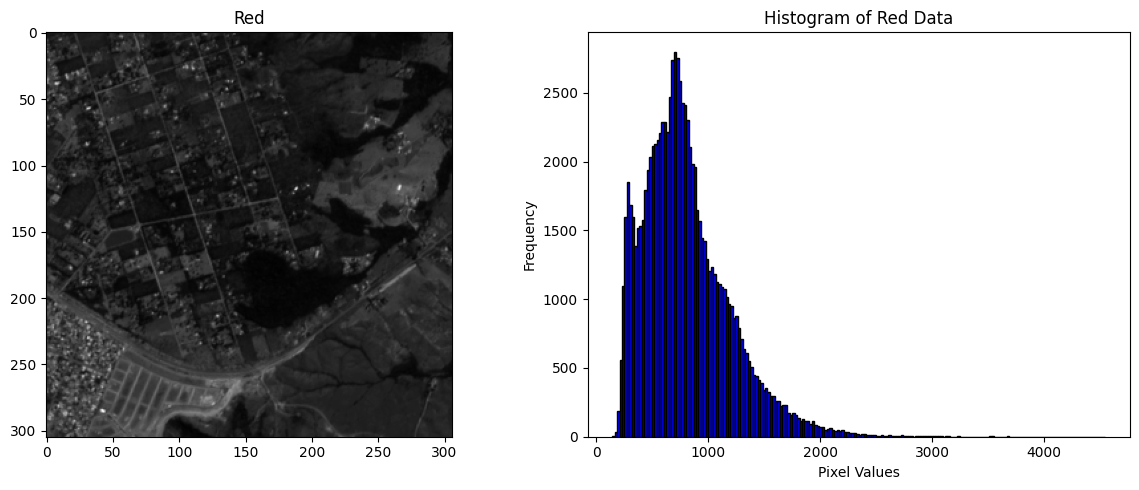

In [15]:
print_imageBand_hist(band_red, 'Red')

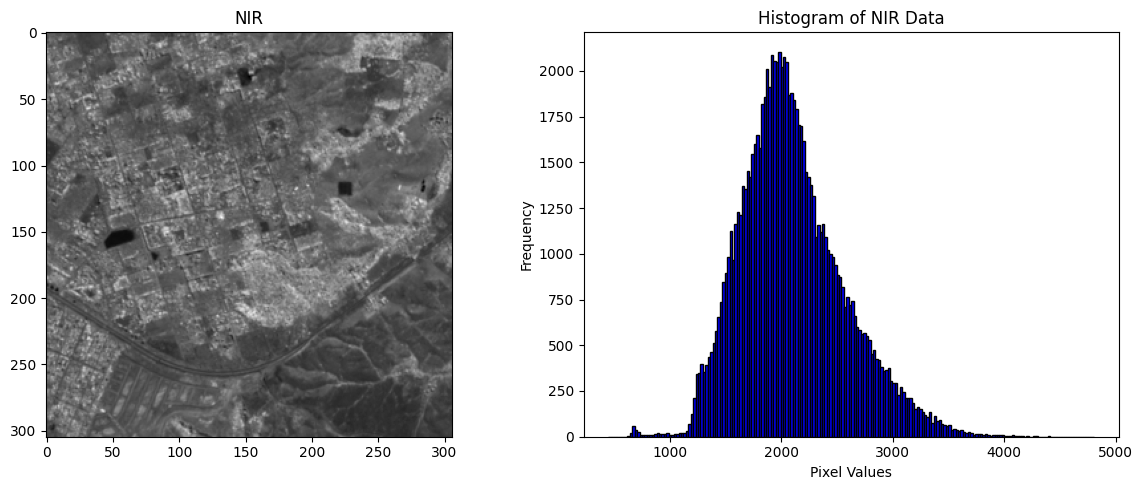

In [16]:
print_imageBand_hist(band_nir, 'NIR')

## Visualize the RGB image from the boundary box (reducing cloud cover with the reflectance median values)

In [17]:
# Select all bands from the Sentinel-2 collection
bands = sentinel_2.select(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'])

# Get the median of the images to reduce cloud cover
median_image = bands.median().clip(bbox)

# Visualize a True Color image (using RGB bands: B4, B3, B2)
rgb_vis = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']
}

# Create an interactive map and add the median image layer
Map = geemap.Map()
Map.centerObject(bbox, 10)
Map.addLayer(median_image, rgb_vis, 'Sentinel-2 True Color')

# Display the map
Map

Map(center=[-15.753758293000404, -47.73300904961768], controls=(WidgetControl(options=['position', 'transparen…

# Download the band images
<hr style="border:1px solid #007700;">

In [18]:
# Date of the image
image_date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()

In [20]:
import requests
import os

# Create a directory to save the downloaded images in Colab
output_folder = './GEE_images'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# List of Sentinel-2 bands to download
bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']

# Loop through each band and download the image as GeoTIFF
for band in bands:
    band_image = image.select(band).clip(bbox)

    download_url = band_image.getDownloadURL({
        'scale': 10,  # Adjust according to the band resolution
        'region': bbox,
        'format': 'GEO_TIFF'
    })

    response = requests.get(download_url)

    # Save the GeoTIFF file in the folder
    file_name = f'{band}_{image_date}.tif'
    file_path = os.path.join(output_folder, file_name)
    with open(file_path, 'wb') as f:
        f.write(response.content)

    print(f'Downloaded and saved {file_name} to {output_folder}')


# Show the content of the folder
print(40*'-')
print('GEE_images folder content:')
!ls -l ./GEE_images

Downloaded and saved B1_2023-09-01.tif to ./GEE_images
Downloaded and saved B2_2023-09-01.tif to ./GEE_images
Downloaded and saved B3_2023-09-01.tif to ./GEE_images
Downloaded and saved B4_2023-09-01.tif to ./GEE_images
Downloaded and saved B5_2023-09-01.tif to ./GEE_images
Downloaded and saved B6_2023-09-01.tif to ./GEE_images
Downloaded and saved B7_2023-09-01.tif to ./GEE_images
Downloaded and saved B8_2023-09-01.tif to ./GEE_images
Downloaded and saved B8A_2023-09-01.tif to ./GEE_images
Downloaded and saved B9_2023-09-01.tif to ./GEE_images
Downloaded and saved B11_2023-09-01.tif to ./GEE_images
Downloaded and saved B12_2023-09-01.tif to ./GEE_images
----------------------------------------
GEE_images folder content:
total 896
-rw-r--r-- 1 root root  57697 Sep 16 23:40 B11_2023-09-01.tif
-rw-r--r-- 1 root root   8089 Sep 16 23:40 B1_2023-09-01.tif
-rw-r--r-- 1 root root  57018 Sep 16 23:40 B12_2023-09-01.tif
-rw-r--r-- 1 root root 129378 Sep 16 23:40 B2_2023-09-01.tif
-rw-r--r-- 1 

In [21]:
# download to a local computer

import shutil
from google.colab import files

# Zip the folder
shutil.make_archive(output_folder, 'zip', output_folder)

# Download the zipped folder
files.download(f'{output_folder}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>